In [ ]:
!pip install opencv-python-headless

In [ ]:
!pip install nano

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
!wget -O yolov3.cfg https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
!wget https://pjreddie.com/media/files/yolov3.weights
!wget -O coco.names https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

--2024-06-19 06:17:09--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8342 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

yolov3.cfg          100%[===================>]   8.15K  --.-KB/s    in 0s      

2024-06-19 06:17:09 (60.2 MB/s) - ‘yolov3.cfg’ saved [8342/8342]

--2024-06-19 06:17:10--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  30.7MB/s    in 8.1s    

2024-06-19 06

In [ ]:
# Assuming the images are named numerically starting from 1.jpg
annotations_file = open("image_data.txt", "w")

# Loop through the images and write annotations to the file
for image_name in sorted(os.listdir('dataset')):
    if image_name.endswith('.jpg'):  # Assuming images are jpg files
        # Assuming you have face detection results and extracted information
        # Replace "Aashik", "18", "male" with your actual data
        annotation = f"{image_name.split('.')[0]} Jeeva 18 Crime_of_browser\n"
        annotations_file.write(annotation)

# Close the file
annotations_file.close()

In [ ]:
!pip install dlib
!pip install imutils

In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=1729bd2ebff2557943b77f0b4269dd2a22f1f02dc80ea5071219205156ef2bc9
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
from google.colab import drive
from zipfile import ZipFile
import cv2 as cv
import numpy as np
import os
import time
import statistics
import dlib
from imutils import face_utils

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your dataset.zip in Google Drive
zip_path = '/content/drive/My Drive/dataset.zip'

# Unzip the dataset
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# List all files and directories in the extracted dataset
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

list_files('dataset')

class Face_Landmark_Tracking:

    def __init__(self, conf_threshold=0.5, nms_threshold=0.4):
        self.conf_threshold = conf_threshold
        self.nms_threshold = nms_threshold

        self.net = cv.dnn.readNet('dataset/d/yolov3.weights', 'dataset/d/yolov3.cfg')
        self.layer_names = self.net.getLayerNames()
        self.output_layers = [self.layer_names[i - 1] for i in self.net.getUnconnectedOutLayers().flatten()]

        with open('dataset/d/coco.names', 'r') as f:
            self.classes = [line.strip() for line in f.readlines()]

        # Initialize dlib's face detector and facial landmark predictor
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor('dataset/d/shape_predictor_68_face_landmarks.dat')

    def findFaces(self, img):
        height, width, channels = img.shape

        blob = cv.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        class_ids = []
        confidences = []
        boxes = []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > self.conf_threshold and self.classes[class_id] == 'person':
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indices = cv.dnn.NMSBoxes(boxes, confidences, self.conf_threshold, self.nms_threshold)
        if len(indices) > 0:
            indices = indices.flatten()
        else:
            indices = []

        return [(boxes[i], confidences[i]) for i in indices]

    def placeLandmarks(self, img, face_box):
        (x, y, w, h) = face_box
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        rect = dlib.rectangle(x, y, x + w, y + h)
        shape = self.predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # Define the indices for the specific landmarks
        landmarks = {
            "left_eye": np.mean(shape[36:42], axis=0).astype(int),
            "right_eye": np.mean(shape[42:48], axis=0).astype(int),
            "nose": shape[30],
            "mouth_left": shape[48],
            "mouth_right": shape[54],
        }

        for point in landmarks.values():
            cv.circle(img, tuple(point), 5, (0, 255, 0), -1)

        # Draw the bounding box around the face
        cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

def main():
    from google.colab.patches import cv2_imshow
    pTime = 0
    cTime = 0
    fps_lst = []

    dataset_folder = 'dataset/d/dataset'

    detector = Face_Landmark_Tracking()
    processed_images = 0

    for image_name in sorted(os.listdir(dataset_folder)):
        img_path = os.path.join(dataset_folder, image_name)
        img = cv.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        faces = detector.findFaces(img)
        if faces:
            for face_box, confidence in faces:
                detector.placeLandmarks(img, face_box)
            processed_images += 1

            cTime = time.time()
            fps = 1 / (cTime - pTime)
            fps_lst.append(fps)
            pTime = cTime

            cv.putText(img, str(int(fps)), (10, 70), cv.FONT_HERSHEY_PLAIN, 3, (0, 255, 0), 3)
            cv2_imshow(img)

            if cv.waitKey(1) == 27:
                break

    if processed_images > 0:
        print("\n******\n [+] AVERAGE FPS :-  ", int(statistics.mean(fps_lst)), "\n******\n")
    else:
        print("No images were processed, cannot calculate average FPS.")

if __name__ == "__main__":
    main()

Mounted at /content/drive


KeyboardInterrupt: 

In [ ]:
!pip install openpyxl
!pip install pillow

In [ ]:
pip freeze > requirements.txt

In [ ]:
pip install -r requirements.txt

  Using cached https://pypi.nvidia.com/cudf-cu12/cudf_cu12-24.4.1-cp310-cp310-manylinux_2_28_x86_64.whl (473.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.1 MB/s eta 0:00:00
Processing /colabtools/dist/google-colab-1.0.0.tar.gz (from -r requirements.txt (line 144))
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/colabtools/dist/google-colab-1.0.0.tar.gz'



In [ ]:
!pip install cudf-cu12==24.4.1
!pip install en-co

ERROR: Could not find a version that satisfies the requirement en-co (from versions: none)
ERROR: No matching distribution found for en-co


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

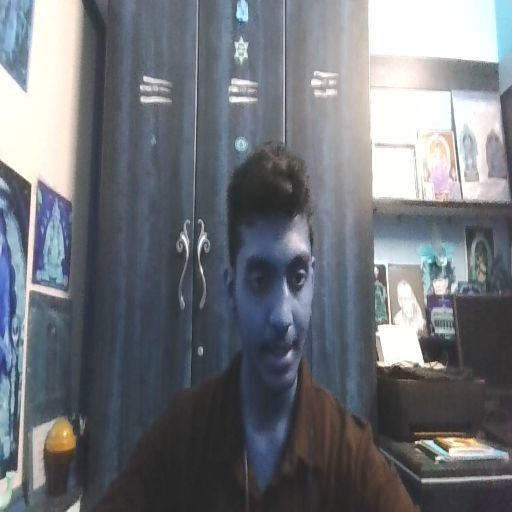

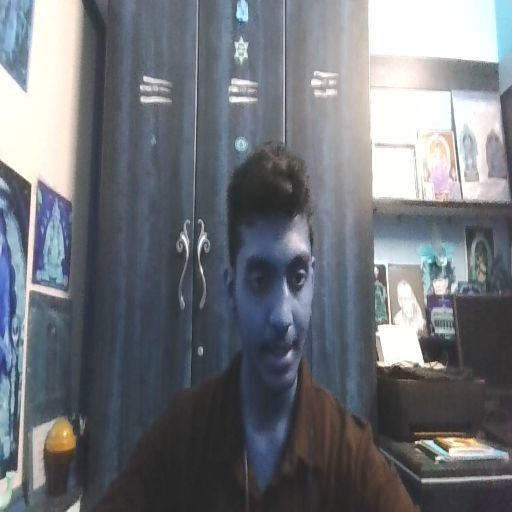

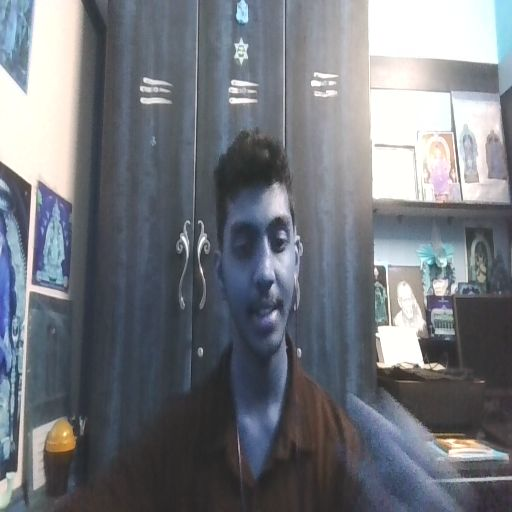

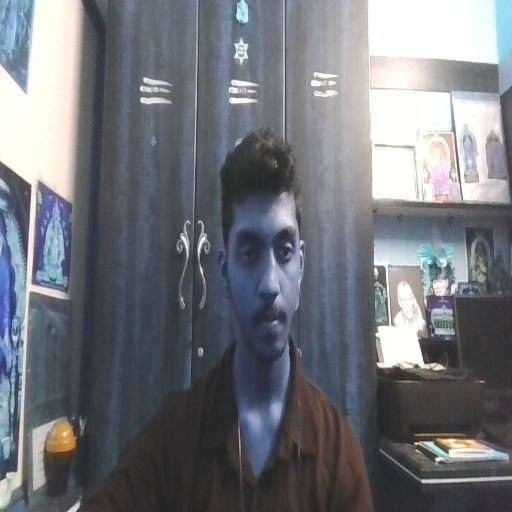

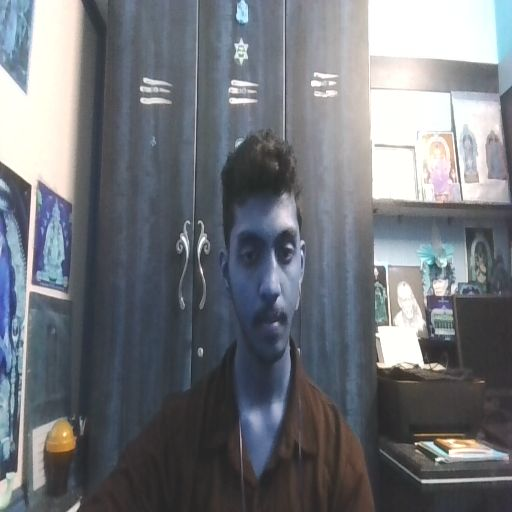

Match found: Aashik_Harishwar, 19, Mastermind_of_Crime


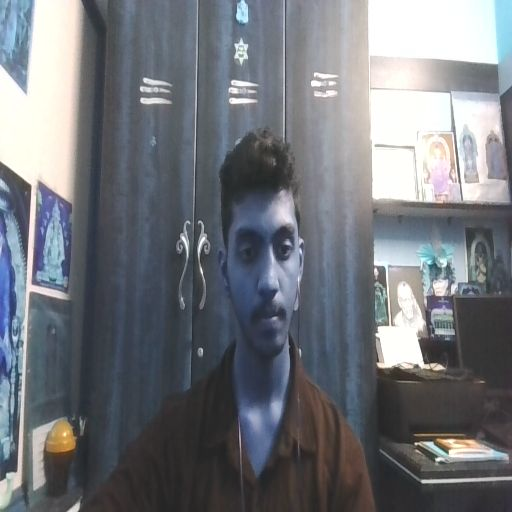

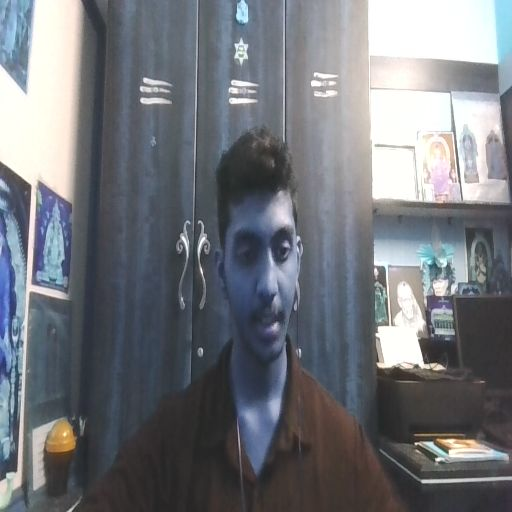

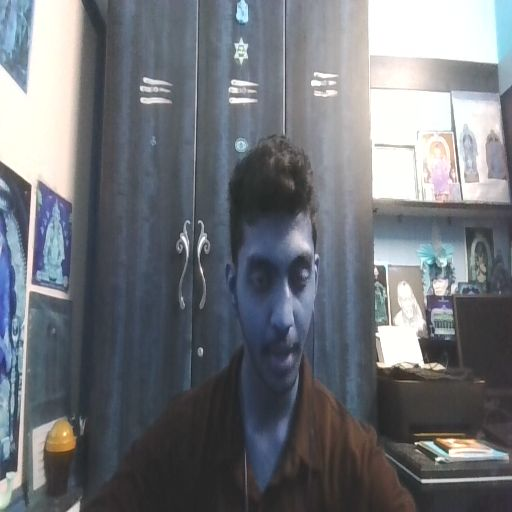

KeyboardInterrupt: 

In [ ]:
# Install required libraries
!pip install dlib
!pip install face_recognition
!pip install imutils

import cv2 as cv
import numpy as np
import os
import time
import statistics
import dlib
import face_recognition  # Import face_recognition library
from imutils import face_utils
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import io
from PIL import Image
import base64

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset.zip in Google Drive
zip_path = '/content/drive/My Drive/dataset.zip'

# Unzip the dataset
from zipfile import ZipFile
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('dataset/d/shape_predictor_68_face_landmarks.dat')

# Read image data from text file
image_data = {}
with open('dataset/d/image_data.txt', 'r') as file:
    for line in file:
        parts = line.strip().split(',')
        if len(parts) == 4:
            image_data[parts[0]] = parts[1:]

# Extract embeddings for dataset images
dataset_embeddings = {}
for img_name, details in image_data.items():
    img_path = os.path.join('dataset/d/dataset', img_name)
    dataset_img = face_recognition.load_image_file(img_path)
    face_encodings = face_recognition.face_encodings(dataset_img)
    if face_encodings:
        dataset_embeddings[img_name] = {
            "details": details,
            "embedding": face_encodings[0]
        }

def js_reply_to_image(js_reply):
    """Converts the JavaScript object returned by take_photo to a numpy array"""
    image_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image = Image.open(io.BytesIO(image_bytes))
    return np.array(image)

def start_input():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

    display(js)

def take_photo(label, img_data):
    js = eval_js(f'takePhoto("{label}", "{img_data}")')
    return js

def main():
    start_input()
    label_html = 'Capturing...'
    img_data = ''
    fps_lst = []
    pTime = time.time()

    initialized = False

    while True:
        js_reply = take_photo(label_html, img_data)
        if not js_reply:
            break

        image = js_reply_to_image(js_reply)
        img_data = js_reply['img']

        if not initialized:
            initialized = True
            cv2_imshow(image)

        # Find only the first face (your face) in the image
        face_locations = face_recognition.face_locations(image)
        face_encodings = face_recognition.face_encodings(image, face_locations)

        if face_encodings:
            for face_encoding in face_encodings:
                matches = face_recognition.compare_faces([data['embedding'] for data in dataset_embeddings.values()], face_encoding)
                face_distances = face_recognition.face_distance([data['embedding'] for data in dataset_embeddings.values()], face_encoding)
                best_match_index = np.argmin(face_distances)
                if matches[best_match_index]:
                    matched_details = list(dataset_embeddings.values())[best_match_index]['details']
                    print(f"Match found: {matched_details[0]}, {matched_details[1]}, {matched_details[2]}")
                else:
                    print("Not a Criminal")

        cv2_imshow(image)

        cTime = time.time()
        fps = 1 / (cTime - pTime)
        fps_lst.append(fps)
        pTime = cTime

        if cv.waitKey(1) == 27:
            break

    cv.destroyAllWindows()

    if len(fps_lst) > 0:
        print("\n******\n [+] AVERAGE FPS :-  ", int(statistics.mean(fps_lst)), "\n******\n")
    else:
        print("No images were processed, cannot calculate average FPS.")

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Please upload an image:


Saving gow.jpg to gow.jpg

Displaying dataset images with bounding boxes and landmarks...



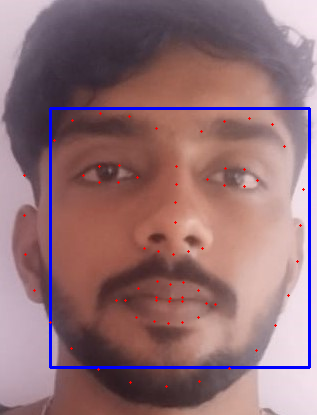

1.jpg : ['Jeeva', '18', 'Crime_of_Browser']


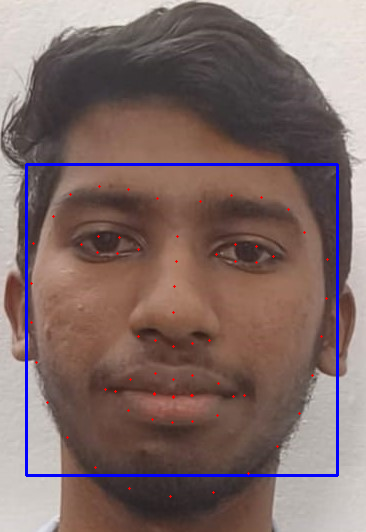

2.jpg : ['Nivash', '18', 'Crime_of_Instagram']


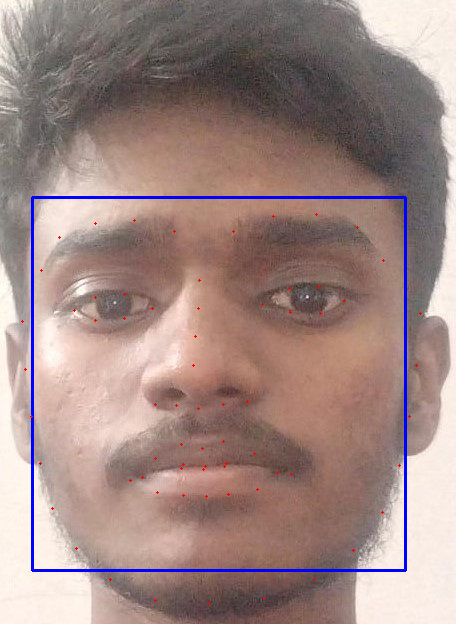

3.jpg : ['Prasannaraj', '18', 'Crime_of_Facebook']


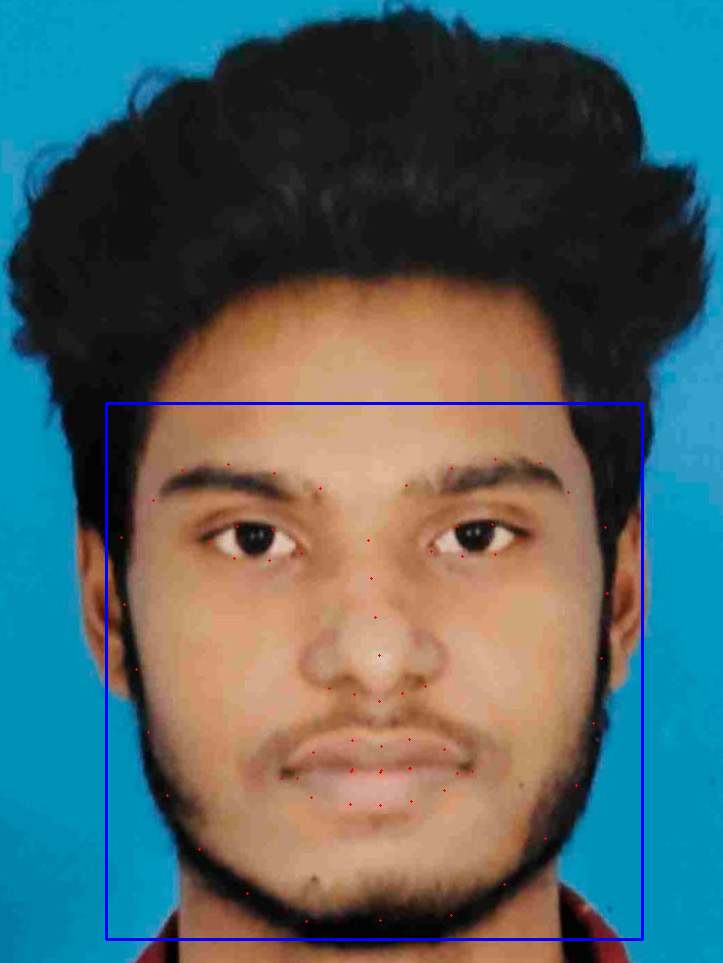

4.jpg : ['Sam_Britto', '18', 'Crime_of_Youtube']


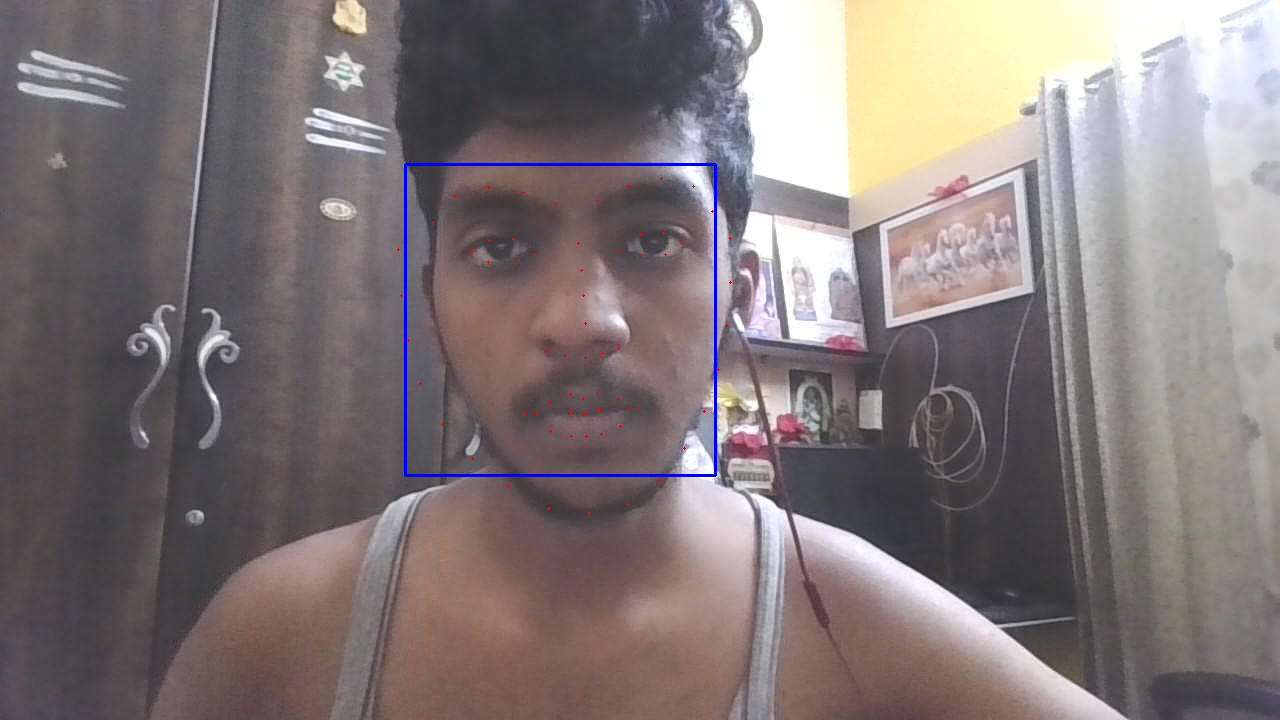

5.jpg : ['Aashik_Harishwar', '19', 'Mastermind_of_Crime']

Processing uploaded image...

Match found! Displaying details: ['Jeeva', '18', 'Crime_of_Browser']


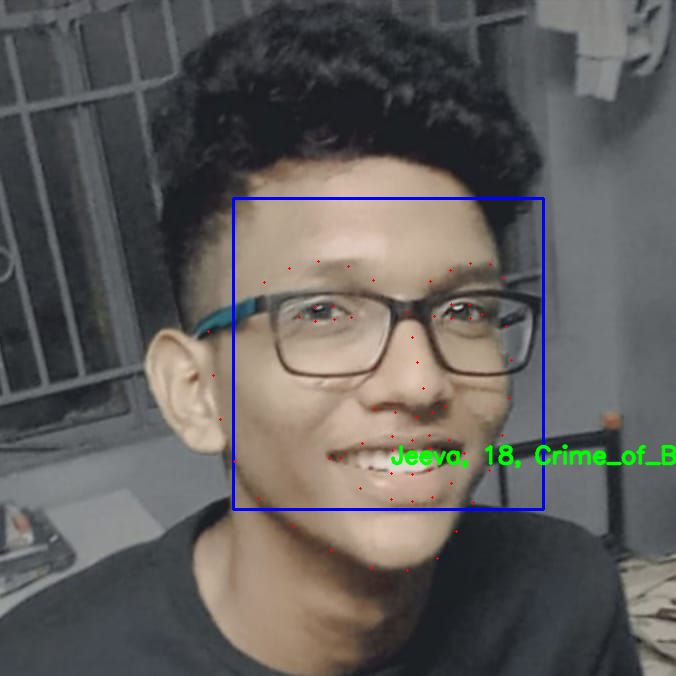

In [ ]:
!pip install face_recognition
import cv2 as cv
import os
import dlib
import face_recognition # The face_recognition library is imported here
from imutils import face_utils
from google.colab.patches import cv2_imshow
from google.colab import files


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your dataset.zip in Google Drive
zip_path = '/content/drive/My Drive/dataset.zip'

# Unzip the dataset
from zipfile import ZipFile
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Initialize dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('dataset/d/shape_predictor_68_face_landmarks.dat')

# Function to upload image
def upload_image():
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = fn
    return path

# Function to display and process dataset images
def display_dataset_images():
    dataset_dir = 'dataset/d/dataset'
    image_data_dir = 'dataset/d/image_data.txt'

    # Read image data
    image_data = {}
    with open(image_data_dir, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) == 4:
                image_data[parts[0]] = parts[1:]

    # Store encodings and corresponding details
    dataset_encodings = []

    # Display images from dataset with bounding boxes and landmarks
    for img_name in sorted(image_data.keys()):
        img_path = os.path.join(dataset_dir, img_name)
        img = cv.imread(img_path)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Detect faces
        faces = detector(gray, 0)
        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
            rect = dlib.rectangle(x, y, x + w, y + h)
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)

            # Draw landmarks
            for (x, y) in shape:
                cv.circle(img, (x, y), 1, (0, 0, 255), -1)

            # Get face encoding
            face_encoding = face_recognition.face_encodings(img, [(y, x + w, y + h, x)])[0]
            dataset_encodings.append((face_encoding, image_data[img_name]))

        cv2_imshow(img)

        # Display details from image_data.txt
        if img_name in image_data:
            details = image_data[img_name]
            print(f"{img_name} : {details}")

    return dataset_encodings

# Function to process uploaded image and compare with dataset
def process_uploaded_image(uploaded_image_path, dataset_encodings):
    uploaded_image = cv.imread(uploaded_image_path)
    rgb_uploaded = cv.cvtColor(uploaded_image, cv.COLOR_BGR2RGB)

    # Detect faces in uploaded image
    faces = detector(cv.cvtColor(uploaded_image, cv.COLOR_BGR2GRAY), 0)
    matched = False

    if faces:
        for face in faces:
            x, y, w, h = face.left(), face.top(), face.width(), face.height()
            cv.rectangle(uploaded_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
            rect = dlib.rectangle(x, y, x + w, y + h)
            shape = predictor(cv.cvtColor(uploaded_image, cv.COLOR_BGR2GRAY), rect)
            shape = face_utils.shape_to_np(shape)

            # Draw landmarks
            for (x, y) in shape:
                cv.circle(uploaded_image, (x, y), 1, (0, 0, 255), -1)

            # Get face encoding
            face_encoding = face_recognition.face_encodings(uploaded_image, [(y, x + w, y + h, x)])[0]

            # Compare with dataset encodings
            for dataset_encoding, details in dataset_encodings:
                matches = face_recognition.compare_faces([dataset_encoding], face_encoding)
                if matches[0]:
                    matched = True
                    print(f"Match found! Displaying details: {details}")
                    cv.putText(uploaded_image, f"{details[0]}, {details[1]}, {details[2]}", (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv.LINE_AA)
                    break

            if matched:
                break

    if not matched:
        print("Not a Criminal")

    cv2_imshow(uploaded_image)

# Main function
def main():
    print("Please upload an image:")
    uploaded_image_path = upload_image()

    print("\nDisplaying dataset images with bounding boxes and landmarks...\n")
    dataset_encodings = display_dataset_images()

    print("\nProcessing uploaded image...\n")
    process_uploaded_image(uploaded_image_path, dataset_encodings)

if __name__ == "__main__":
    main()

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!python -m venv my_env
!source my_env/bin/activate

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/my_env/bin/python3

/bin/bash: line 1: my_env/bin/activate: No such file or directory


In [ ]:
!apt-get update
!apt-get install -y cuda

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Err:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcon

In [ ]:
!pip install opencv-python dlib face_recognition imutils

In [ ]:
!nvidia-smi # Check the CUDA version supported by your drivers
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
!mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
!apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub
!add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/ /"
!apt-get update
!apt-get -y install cuda-toolkit-11-7 # Replace 11-7 with the appropriate version

/bin/bash: line 1: nvidia-smi: command not found
--2024-06-19 10:44:13--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2004.pin’

cuda-ubuntu2004.pin 100%[===================>]     190  --.-KB/s    in 0s      

2024-06-19 10:44:13 (1.79 MB/s) - ‘cuda-ubuntu2004.pin’ saved [190/190]

Executing: /tmp/apt-key-gpghome.wkTaK6JRdR/gpg.1.sh --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub
gpg: requesting key from 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/7fa2af80.pub'
gpg: key F60F4B3D7FA2AF80: public key "cudatools <cudatools@nvidia.com>" imported
gpg: To

In [ ]:
!pip install face_recognition